In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_env as pe
import sklearn as sklearn
%matplotlib inline

In [76]:
data_train = pd.read_csv('data_train_enc.csv', encoding = "ISO-8859-1", low_memory=False)
data_val = pd.read_csv('data_val_enc.csv', encoding = "ISO-8859-1", low_memory=False)

# Target Variable

In [77]:
#target variable of rearrest in 2 years
X_train, y_train = pe.create_target(data_train, years = 2)
X_val, y_val = pe.create_target(data_val, years = 2)

In [78]:
len(X_train)

78539

In [79]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 36.557633787 percent were rearrested.
Test: 37.0308123249 percent were rearrested.


In [80]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['DOB','ARREST_DATE','POLICE_RPT_DATE','SCREENING_DISP_DATE',\
                      'BAR_ADMISSION','ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['DOB','ARREST_DATE','POLICE_RPT_DATE','SCREENING_DISP_DATE',\
                  'BAR_ADMISSION','ARREST_DATE_y'], axis=1)


In [81]:
#check for missing val
X_train.count().min()==X_train.count().max()

True

# Gradient Boosted Trees

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train,y_train)

pred_train = gbt.predict(X_train)
pred_val = gbt.predict(X_val)


In [83]:
#accuracy

accu_train = sklearn.metrics.accuracy_score(y_train,pred_train)
accu_test = sklearn.metrics.accuracy_score(y_val,pred_val)

print("Accuracy on Training Dataset: {}".format(accu_train))
print("Accuracy on Val Dataset: {}".format(accu_test))

Accuracy on Training Dataset: 0.6956671207934911
Accuracy on Val Dataset: 0.6902979373567609


In [84]:
precision = sklearn.metrics.precision_score(y_val,pred_val)
recall = sklearn.metrics.recall_score(y_val,pred_val)
f_score = sklearn.metrics.f1_score(y_val,pred_val)

print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-Score: {}".format(f_score))

Precision: 0.621676891615542
Recall: 0.41809929858341355
F-Score: 0.4999588849601184


In [85]:
#confusion matrix for val set
cm = sklearn.metrics.confusion_matrix(y_val,pred_val)
cm

array([[10514,  1850],
       [ 4231,  3040]])

## Bivariate Correlation Between Features and Target

In [163]:
numeric_columns_corr = ['NEXT_ARREST_TIME',
 'CRIMINAL_FLAG',
 'FINAL_DETENTION_FLAG',
 'HABITUAL_OFFENDER_FLAG',
 'INITIAL_DETENTION_FLAG',
 'JUVENILE_FLAG',
 'TOT_NUM_DEF',
 'MULTIPLE_DEF_FLAG',
 'SCREENING_DAYS',
 'POLICE_RPT_DAYS',
 'POLICE_RPT_DATE_y',
 'ARREST_DATE_y',
 'DOB_y',
 'SCREENING_DISP_DATE_y',
 'BAR_ADMISSION_y',
 'POLICE_RPT_DATE_m',
 'ARREST_DATE_m',
 'DOB_m',
 'SCREENING_DISP_DATE_m',
 'BAR_ADMISSION_m']

In [129]:
numeric_columns_boxplot = ['NEXT_ARREST_TIME',
 'TOT_NUM_DEF',
 'SCREENING_DAYS',
 'POLICE_RPT_DAYS',
 'POLICE_RPT_DATE_y',
 'ARREST_DATE_y',
 'DOB_y',
 'SCREENING_DISP_DATE_y',
 'BAR_ADMISSION_y',
 'POLICE_RPT_DATE_m',
 'ARREST_DATE_m',
 'DOB_m',
 'SCREENING_DISP_DATE_m',
 'BAR_ADMISSION_m']

In [ ]:
#Make a class that uses a y_pred, a dataset, and maybe numeric/categorical variables and does:

#comparison of means/boxplots
#comparison of bivariate correlations
#comparison of categorical distributions

In [89]:
#added line in Merge Features that exports the training set before encoding so that we can conduct error analysis
#import the data from before encoding here

err_analysis = pd.read_csv('data_train.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0, )
err_analysis, y_train = pe.create_target(err_analysis, years = 2)

In [120]:
err_analysis['True_Y'] = y_train.copy()
err_analysis['Pred_Y'] = pred_train.copy()
err_analysis['CORRECT'] = np.where((err_analysis['True_Y'] == err_analysis['Pred_Y']), 1, 0)

In [123]:
wrong_pred = err_analysis[err_analysis['CORRECT'] == 0]
right_pred = err_analysis[err_analysis['CORRECT'] == 1]

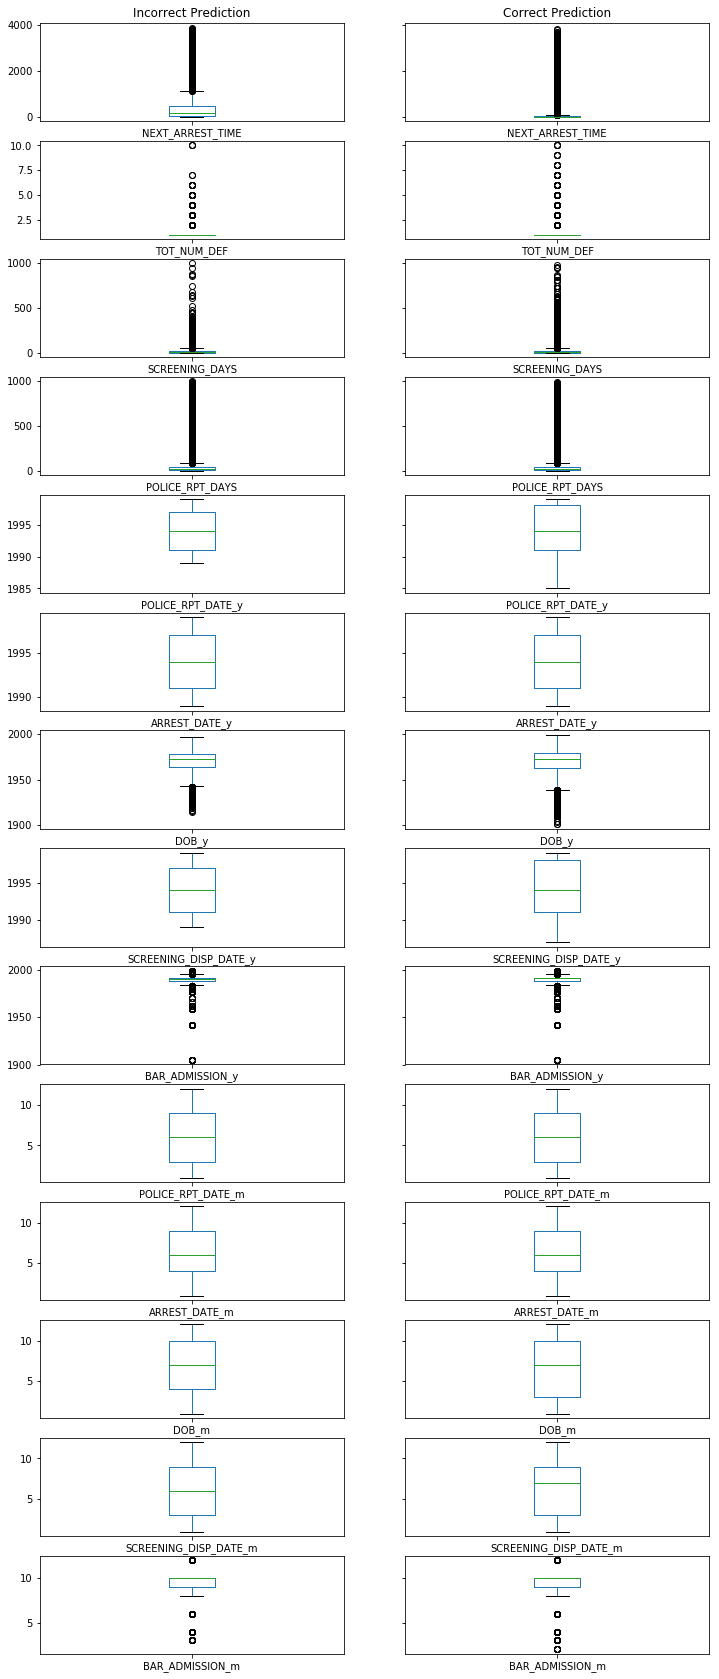

In [161]:
plt.figure(1)
plt.gcf().set_size_inches(12,30) 

rows = len(numeric_columns_boxplot)

i = 1

for variable in numeric_columns_boxplot:
    ax1 = plt.subplot(rows,2,i)
    if i ==1:
        ax1.set_title('Incorrect Prediction')
    wrong_pred[variable].plot.box()
    i = i + 1
    ax2 = plt.subplot(rows,2,i, sharey=ax1)
    if i ==2:
        ax2.set_title('Correct Prediction')
    right_pred[variable].plot.box()
    i = i + 1

In [21]:
desc_wrong_pred = err_analysis[err_analysis['True_Y'] != err_analysis['Pred_Y']].describe()
desc_right_pred = err_analysis[err_analysis['True_Y'] == err_analysis['Pred_Y']].describe()

In [90]:
mean_wrong_pred = desc_wrong_pred.loc['mean',]
mean_right_pred = desc_right_pred.loc['mean',]
pd.concat([mean_wrong_pred, mean_right_pred], axis=1).iloc[:-4, :]

#only noticeable difference is next_arrest_time
#some of these "means" should be interpreted as proportions

,mean,mean
UNIQUE_ID,132587.348214,151620.034738
NEXT_ARREST_TIME,399.848674,128.171258
CRIMINAL_FLAG,0.819346,0.761041
FINAL_DETENTION_FLAG,0.014601,0.012757
HABITUAL_OFFENDER_FLAG,0.000293,0.000403
INITIAL_DETENTION_FLAG,0.016777,0.012977
JUVENILE_FLAG,0.339553,0.334407
SADA_SEX,0.447243,0.386661
SEX,0.869007,0.738273
TOT_NUM_DEF,1.051167,1.054597


In [164]:
err_analysis[numeric_columns_corr].corrwith(err_analysis['True_Y'], )

NEXT_ARREST_TIME          0.004940
CRIMINAL_FLAG             0.108573
FINAL_DETENTION_FLAG      0.005445
HABITUAL_OFFENDER_FLAG    0.000548
INITIAL_DETENTION_FLAG    0.023789
JUVENILE_FLAG             0.033279
TOT_NUM_DEF               0.019814
MULTIPLE_DEF_FLAG         0.026792
SCREENING_DAYS           -0.008587
POLICE_RPT_DAYS          -0.024399
POLICE_RPT_DATE_y        -0.130823
ARREST_DATE_y            -0.131676
DOB_y                     0.051873
SCREENING_DISP_DATE_y    -0.129971
BAR_ADMISSION_y          -0.041911
POLICE_RPT_DATE_m        -0.010652
ARREST_DATE_m            -0.016602
DOB_m                     0.033421
SCREENING_DISP_DATE_m    -0.022142
BAR_ADMISSION_m          -0.000187
dtype: float64

### Is the model is more likely to incorrectly predict no rearrest if the rearrest is very far in the future?

#### Incorrectly Predicted No Rearrest

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118d84d30>]], dtype=object)

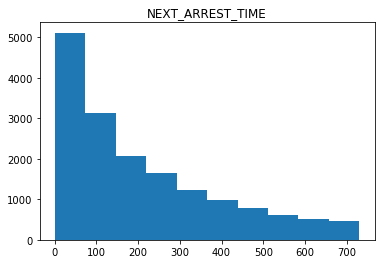

In [95]:
err_analysis[(err_analysis['True_Y'] == 1) & (err_analysis['Pred_Y'] == 0)]\
.hist(column = 'NEXT_ARREST_TIME', grid=False)


#### Correctly Predicted Rearrest

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ffab5c0>]], dtype=object)

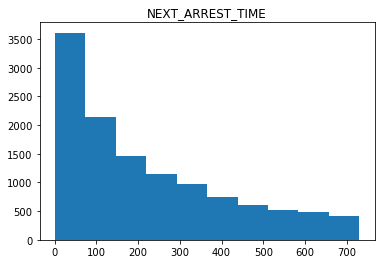

In [96]:
err_analysis[(err_analysis['True_Y'] == 1) & (err_analysis['Pred_Y'] == 1)]\
.hist(column = 'NEXT_ARREST_TIME', grid=False)


### Compare distribution of categorical variables

In [97]:
cat_var =['ARREST_CREDIT_CODE', 'CHARGE_CLASS', 'CHARGE_TYPE', 'LEAD_CHARGE_CODE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

In [98]:
pct_cat_wrong = {}
pct_cat_right = {}
pct_cat_compare = {}

for var in cat_var:
    pct_cat_right[var] = err_analysis[err_analysis['True_Y'] == err_analysis['Pred_Y']]\
    [var].value_counts()/len(err_analysis[err_analysis['True_Y'] == err_analysis['Pred_Y']])
    
    pct_cat_wrong[var] = err_analysis[err_analysis['True_Y'] != err_analysis['Pred_Y']]\
    [var].value_counts()/len(err_analysis[err_analysis['True_Y'] != err_analysis['Pred_Y']])
    
    pct_cat_compare[var] = pd.concat([pd.DataFrame(pct_cat_wrong[var]), pd.DataFrame(pct_cat_right[var])], axis=1)
    pct_cat_compare[var].columns = ['Incorrectly Predicted', 'Correctly Predicted']
    

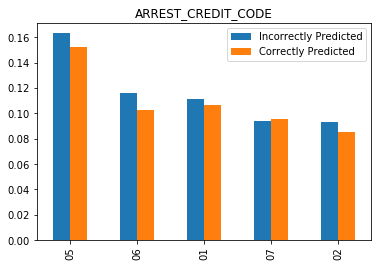

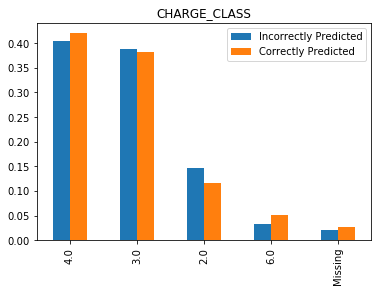

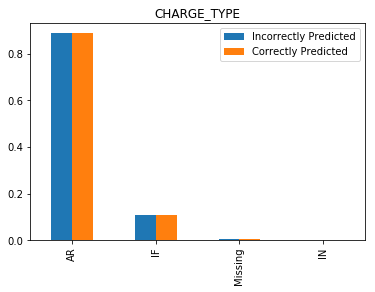

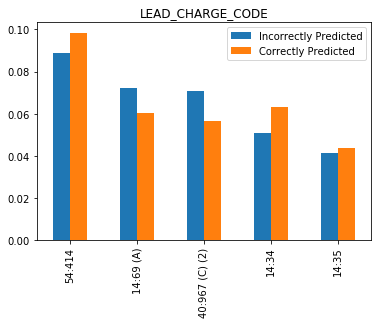

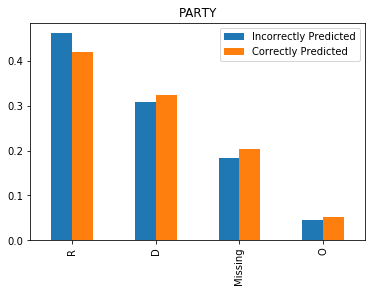

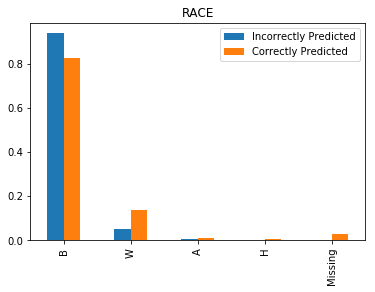

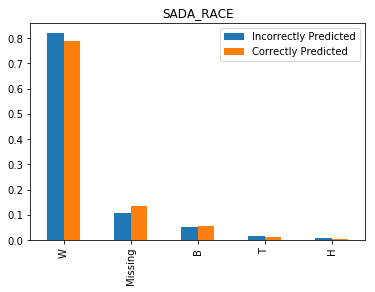

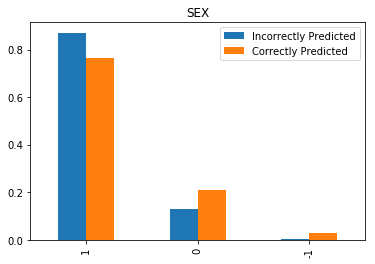

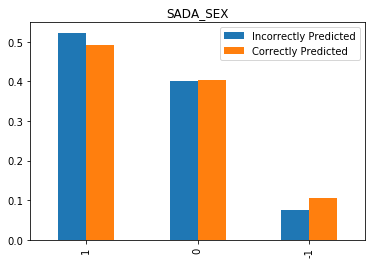

In [189]:
plt.figure(1)

for var in cat_var:
    pct_cat_compare[var].sort_values(by='Incorrectly Predicted', ascending=False).head().plot.bar(title=var)

plt.show()